In [1]:
# !pip install xgboost

In [2]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from keras import Model, Sequential
from keras.layers import Dense, Dropout
from keras.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import joblib
import xgboost as xgb
print("XGB Version:", xgb.__version__)

XGB Version: 2.0.0


In [3]:
# carregar os dados de entrada
inputs_file = 'input_db_29_08_2023_14_26_20.pkl'
with open(inputs_file, 'rb') as handle_inputs:
    inputs = pickle.load(handle_inputs)

In [4]:
inputs.head()

,site_lat,site_long,sat_long,freq,eirp,hsat,bw_total,bw_util,rolloff,mod,fec,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,35786,36,16.155547,0.2,32APSK,126/180,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,35786,36,22.226415,0.2,32APSK,135/180,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518
2,-19.167619,-34.986496,-2.622435,5.349325,56.252903,35786,36,35.827805,0.2,64APSK,162/180,19.590329,1.207189,0.530488,57.036432,28.600282,5.894995,1.506105
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,35786,36,14.203504,0.2,8PSK,100/180,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,35786,36,9.488156,0.2,32APSK,126/180,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052


In [5]:
inputs = inputs.drop(columns=["hsat", "bw_total", "mod", "fec", "rolloff"])

In [6]:
# carregar os dados de saída - 
# apenas a coluna availability é relevante para o problema, 
# pode-se ignorar as demais para o treinamento e teste
results_file = 'results_db_29_08_2023_14_26_20.pkl'
with open(results_file, 'rb') as handle_results:
    results = pickle.load(handle_results)

In [7]:
results.head()

,availability,a_fs,a_g,a_c,a_r,a_s,a_t,a_tot,a_depoint,c_n0,...,earth_radius,elevation_angle,distance,fig_merit,noise_ground,noise_sky,ant_noise,noise_total,ant_gain,ant_3db
0,99.904,207.841452,0.322924,0.966845,9.079432,0.526741,10.383000,220.241483,2.017030,84.759447,...,6367.489544,43.741256,37499.215397,24.276649,10.0,10.860506,260.815713,286.308799,43.398944,1.263074
1,99.999,201.903879,0.065287,0.201974,7.102761,0.439884,7.383255,277.812514,68.525380,112.688241,...,6367.489544,56.474767,36698.322584,95.134206,10.0,3.208548,235.351027,248.680367,46.873483,0.591097
2,96.460,198.393586,0.065097,0.039061,0.016178,0.116006,0.193583,201.164695,2.577525,-99916.332614,...,6367.489544,47.007765,37271.796260,-100000.000000,10.0,3.867110,25.687222,54.289160,33.854824,3.249709
3,99.999,206.567603,0.201870,0.712902,27.381892,0.930295,28.312062,241.951596,7.071931,86.145051,...,6367.489544,59.412644,36547.299501,23.855004,10.0,5.183472,284.602019,314.728183,39.509835,1.408672
4,99.990,207.986262,0.381950,1.032110,16.817812,0.716087,18.246230,232.308445,6.075953,82.544269,...,6367.489544,37.330831,37986.968867,26.033504,10.0,12.583786,281.070225,302.118263,43.249134,0.517240


In [8]:
# preprocessamento da base de dados - 
# as linhas cuja coluna fig_merit têm valor igual a -100000 
# são casos inválidos e devem ser removidos 
filter_matrix = results.fig_merit != -100000
print(filter_matrix.head())
print(np.sum(filter_matrix))

0     True
1     True
2    False
3     True
4     True
Name: fig_merit, dtype: bool
1457619


In [9]:
filtered_inputs = inputs[filter_matrix]
filtered_results = results[filter_matrix]

           site_lat     site_long      sat_long          freq          eirp  \
count  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean  -1.505471e+01 -5.330440e+01 -5.230916e+01  1.132981e+01  5.091215e+01   
std    1.061157e+01  1.080609e+01  3.258509e+01  4.041949e+00  1.763086e+01   
min   -3.368997e+01 -7.288998e+01 -1.079999e+02  3.000049e+00  1.500033e+01   
25%   -2.430390e+01 -6.240066e+01 -8.093161e+01  7.965716e+00  3.691857e+01   
50%   -1.470179e+01 -5.317498e+01 -5.223987e+01  1.150008e+01  5.183633e+01   
75%   -5.817384e+00 -4.398199e+01 -2.366515e+01  1.483480e+01  6.597661e+01   
max    2.819986e+00 -3.480004e+01  2.999920e+00  1.799999e+01  7.999994e+01   

            bw_util  snr_threshold      ant_size       ant_eff      lnb_gain  \
count  1.457619e+06   1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean   1.850569e+01   8.798743e+00  2.383836e+00  5.565397e-01  5.999881e+01   
std    1.009771e+01   5.843946e+00  1.251949e+00

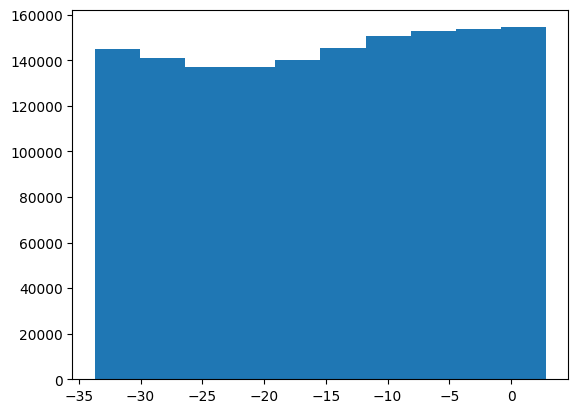

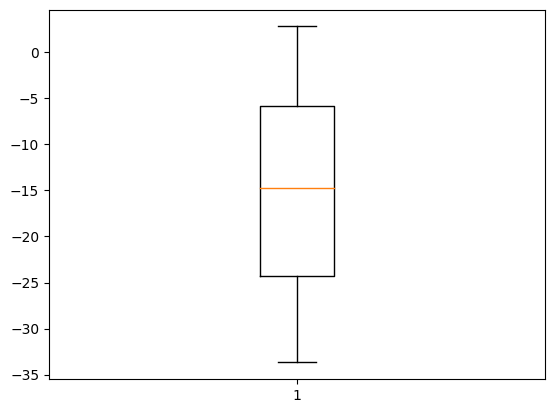

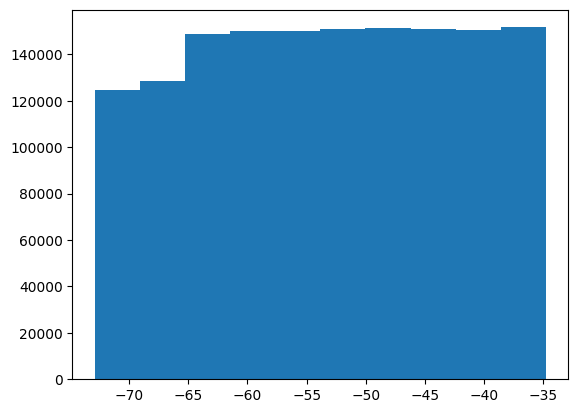

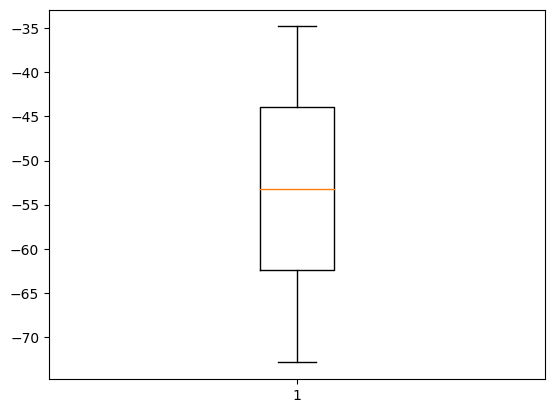

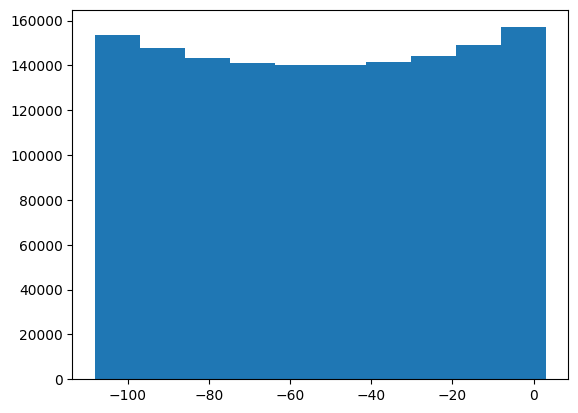

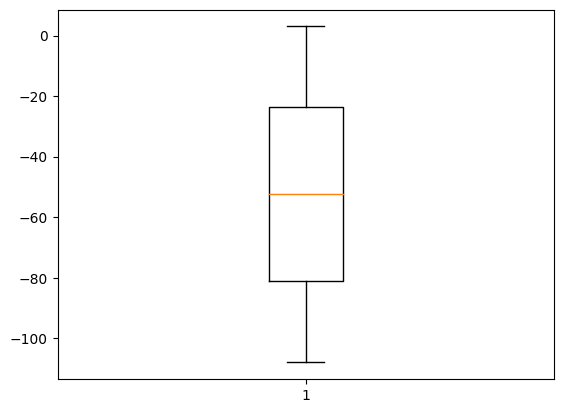

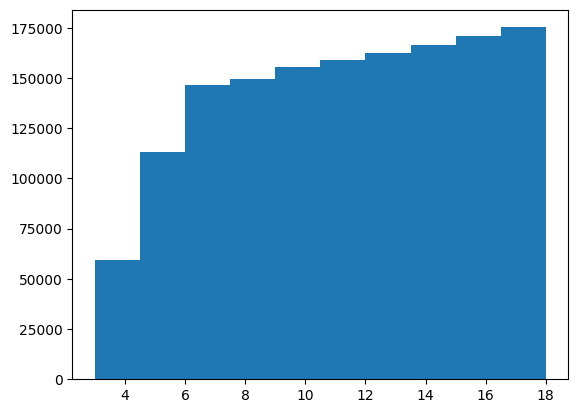

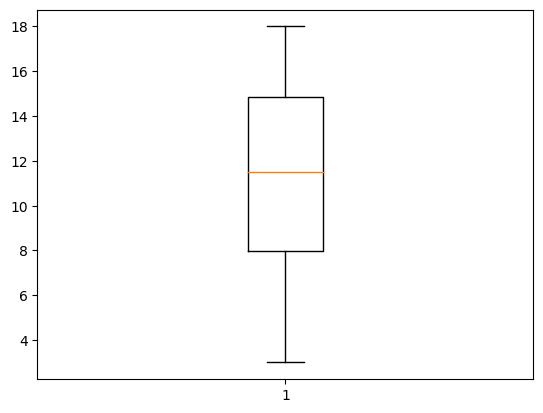

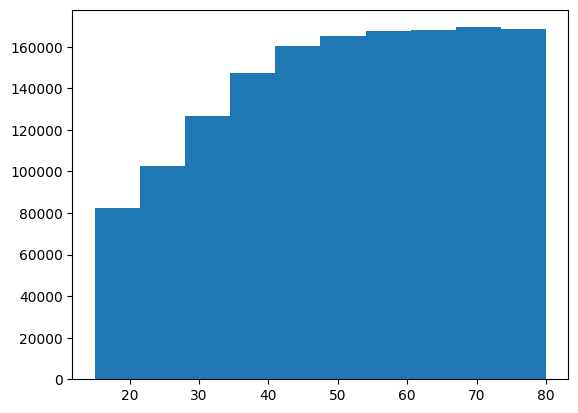

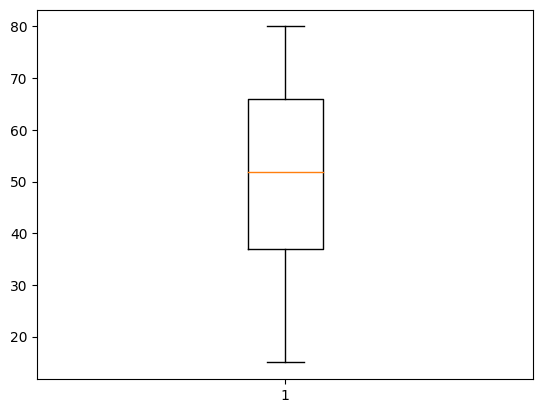

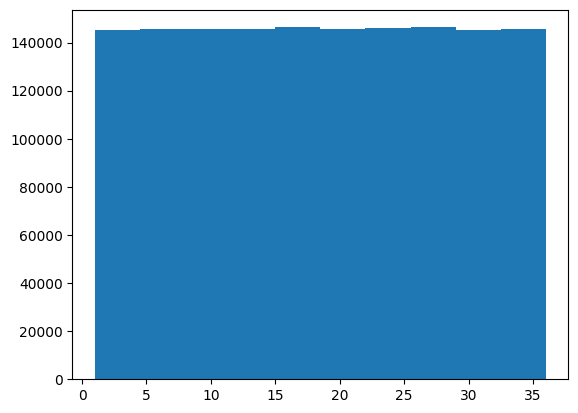

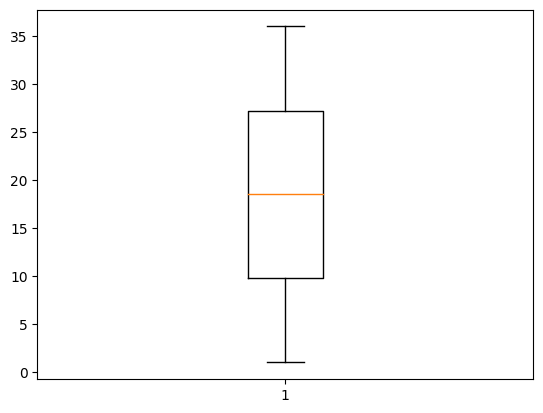

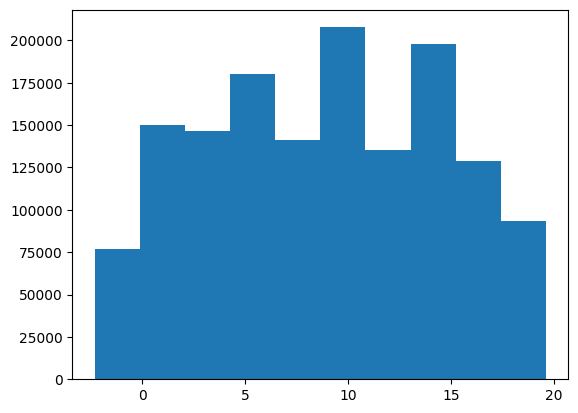

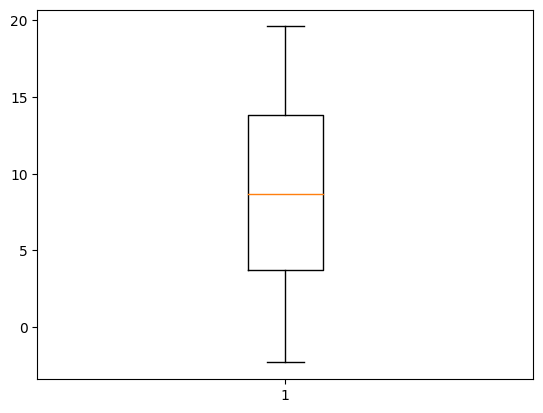

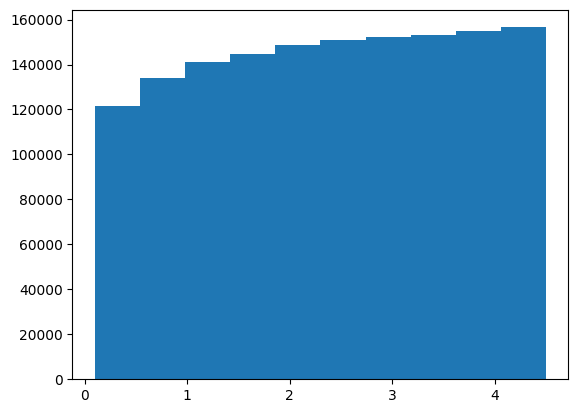

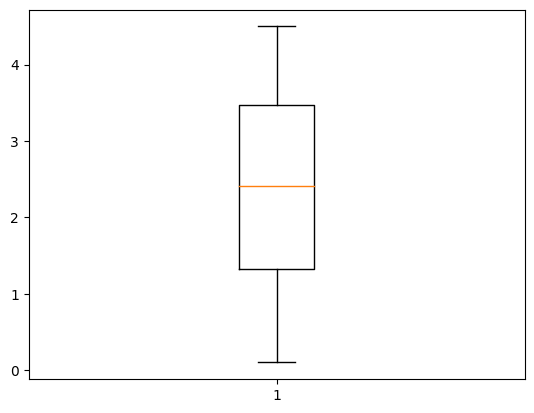

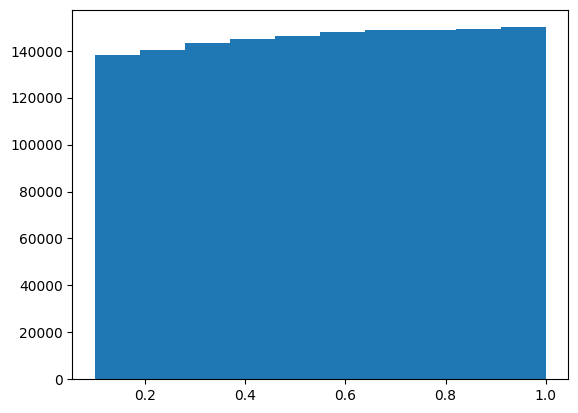

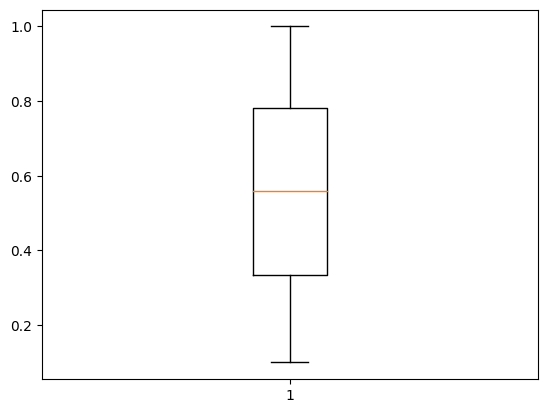

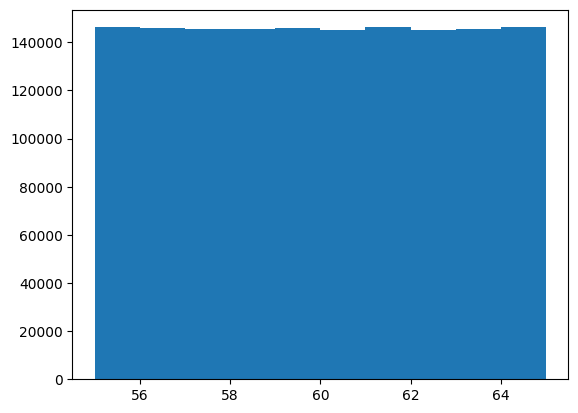

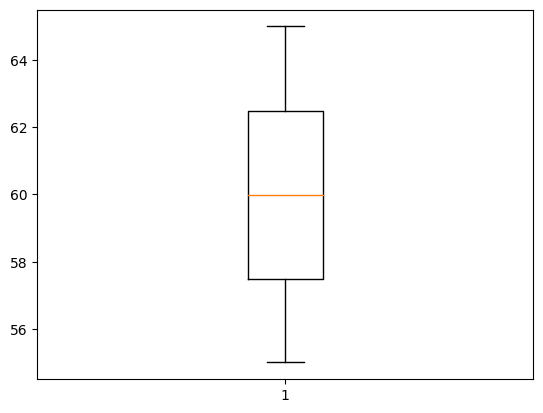

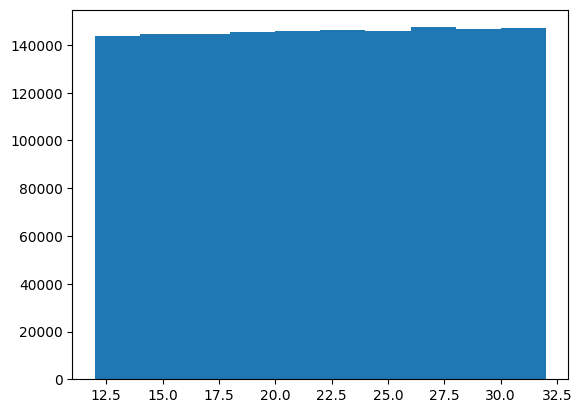

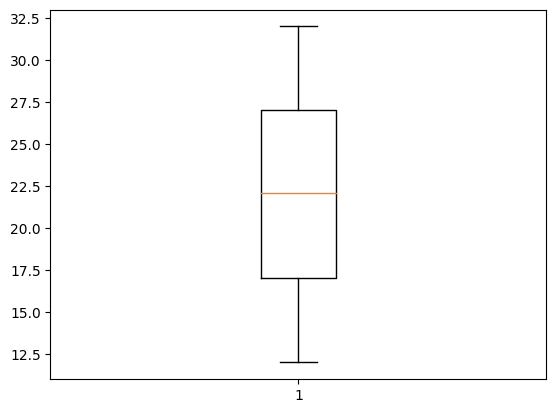

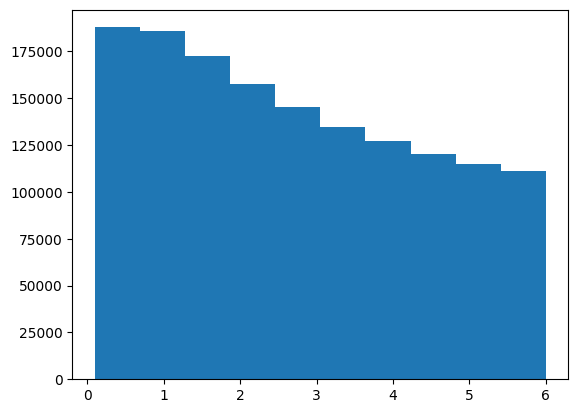

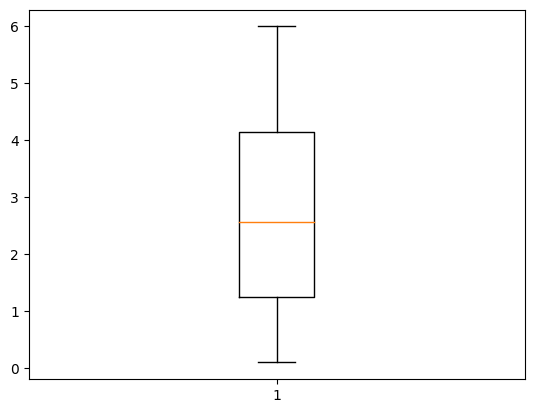

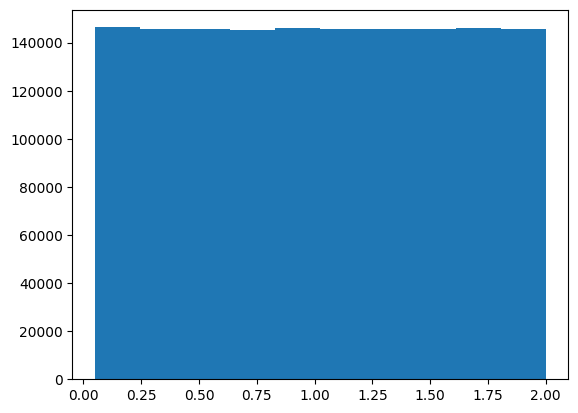

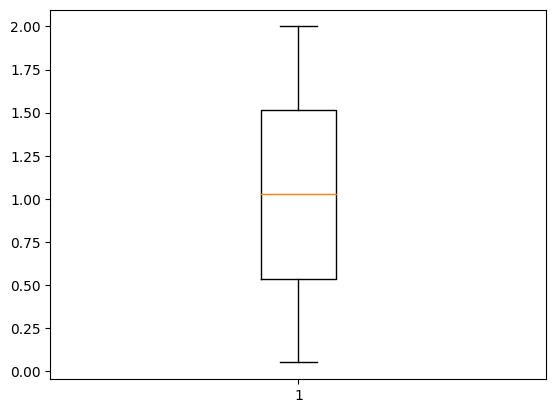

In [10]:
print(filtered_inputs.describe())
for column in inputs.columns:
    # Creating plot
    plt.hist(filtered_inputs[column])
    plt.show()
    plt.boxplot(filtered_inputs[column])
    plt.show()

In [11]:
filtered_results["availability"].describe()

count    1.457619e+06
mean     9.929238e+01
std      1.374950e+00
min      9.500000e+01
25%      9.964200e+01
50%      9.999200e+01
75%      9.999900e+01
max      9.999900e+01
Name: availability, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x306d94fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x306d411b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x306d94970>],
 'medians': [<matplotlib.lines.Line2D at 0x306d40790>],
 'fliers': [<matplotlib.lines.Line2D at 0x103d06650>],
 'means': []}

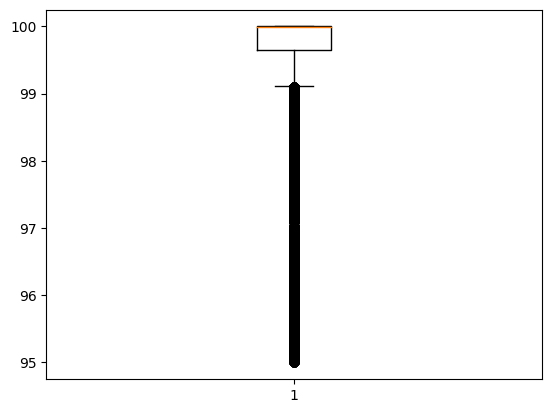

In [12]:
plt.boxplot(filtered_results["availability"])

(array([1.17000e+02, 1.43000e+02, 1.97000e+02, 2.01000e+02, 4.56000e+02,
        2.87000e+02, 3.21000e+02, 3.34000e+02, 6.35000e+02, 3.57000e+02,
        3.67000e+02, 3.93000e+02, 7.40000e+02, 3.59000e+02, 4.04000e+02,
        4.30000e+02, 7.46000e+02, 3.59000e+02, 4.23000e+02, 3.98000e+02,
        7.65000e+02, 3.63000e+02, 4.11000e+02, 3.57000e+02, 7.39000e+02,
        4.06000e+02, 3.83000e+02, 4.02000e+02, 6.89000e+02, 4.39000e+02,
        4.02000e+02, 3.95000e+02, 7.55000e+02, 4.18000e+02, 3.94000e+02,
        4.01000e+02, 7.20000e+02, 4.17000e+02, 3.95000e+02, 4.33000e+02,
        7.08000e+02, 3.88000e+02, 3.76000e+02, 4.02000e+02, 7.64000e+02,
        3.99000e+02, 4.09000e+02, 3.98000e+02, 7.66000e+02, 3.49000e+02,
        4.01000e+02, 3.84000e+02, 7.36000e+02, 3.44000e+02, 2.29000e+03,
        1.49900e+03, 2.83600e+03, 1.46600e+03, 1.43900e+03, 1.47200e+03,
        2.79600e+03, 1.45200e+03, 1.52800e+03, 1.47600e+03, 2.79600e+03,
        1.46300e+03, 1.50700e+03, 1.54100e+03, 2.91

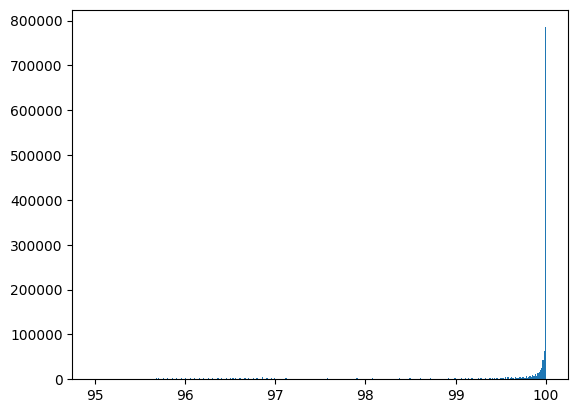

In [13]:
plt.hist(filtered_results["availability"], bins=400)

In [14]:
df = filtered_inputs.assign(availability=filtered_results["availability"])
df.head()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,16.155547,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839,99.904
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,22.226415,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518,99.999
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,14.203504,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404,99.999
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,9.488156,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052,99.990
5,-17.303467,-41.668725,-66.343144,12.480028,27.720772,31.814645,8.326742,4.452849,0.583401,64.208048,17.289375,2.862834,1.010339,99.554


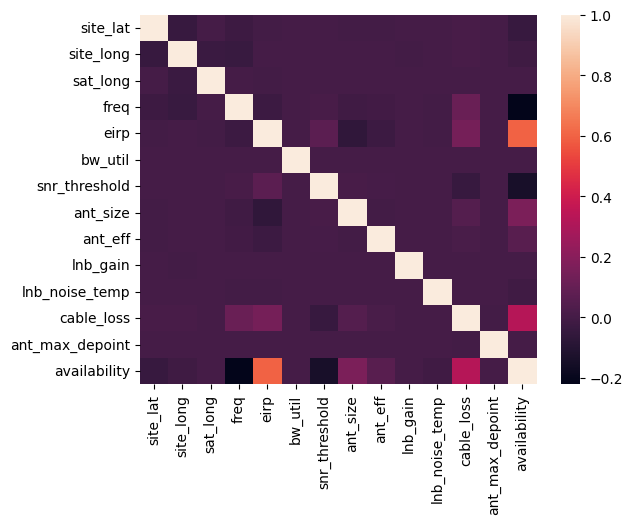

In [15]:
sns.heatmap(df.corr())
plt.show()

In [16]:
df_majority_data = df[df['availability'] >= 99.5]
df_minority_data = df[df['availability'] < 99.5]

In [17]:
df_minority_data.count()

site_lat           333973
site_long          333973
sat_long           333973
freq               333973
eirp               333973
bw_util            333973
snr_threshold      333973
ant_size           333973
ant_eff            333973
lnb_gain           333973
lnb_noise_temp     333973
cable_loss         333973
ant_max_depoint    333973
availability       333973
dtype: int64

In [18]:
df_data_undersample = df_majority_data.sample(int(df_minority_data['availability'].count()/2))

In [19]:
df_balanced = pd.concat([df_data_undersample, df_minority_data], axis=0)
print(df_balanced.head())
df_balanced.describe()

          site_lat  site_long    sat_long       freq       eirp    bw_util  \
131032  -13.979905 -64.709782  -13.317987   9.308482  60.335689  22.106230   
625509  -26.605943 -63.852141  -52.524983   9.732503  36.806435  13.977430   
295986   -5.539122 -52.220544  -41.645188  17.696904  79.112498  33.618318   
1652905 -27.697759 -58.487851  -19.833760  17.474350  49.407641   3.357324   
1830725 -21.296870 -41.902118 -106.155913  11.292788  42.269654  25.572123   

         snr_threshold  ant_size   ant_eff   lnb_gain  lnb_noise_temp  \
131032       12.258633  1.598677  0.752094  60.161156       15.241346   
625509        8.670497  3.300129  0.247776  59.601458       12.390935   
295986        9.543772  0.922363  0.791504  58.200076       22.892309   
1652905      19.258551  2.830453  0.760016  58.137496       13.262880   
1830725       2.840283  3.055198  0.585401  57.159912       23.548693   

         cable_loss  ant_max_depoint  availability  
131032     0.421797         1.035018   

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
count,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.00000
mean,-14.441800,-53.079728,-52.377932,12.375051,39.995913,18.494934,9.606570,2.191396,0.542166,59.999914,22.097471,2.230403,1.025461,98.01825
std,10.659065,10.692522,33.580087,3.949765,17.161963,10.100383,5.797901,1.281028,0.260433,2.889432,5.770163,1.584883,0.563156,1.73536
min,-33.689911,-72.889982,-107.999154,3.000064,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000150,0.100010,0.050010,95.00000
25%,-23.722276,-62.007096,-82.685415,9.419880,26.060725,9.735902,5.134135,1.063903,0.315042,57.499808,17.118441,0.891022,0.537714,96.35000
50%,-13.660698,-52.901552,-52.339909,13.046249,36.685304,18.499315,9.605005,2.141743,0.538697,59.997932,22.140118,1.875810,1.025663,98.27600
75%,-5.076332,-43.885740,-22.054662,15.770773,51.478211,27.233778,14.211092,3.292188,0.766834,62.500218,27.107675,3.342237,1.513995,99.97600
max,2.819986,-34.800075,2.999885,17.999990,79.999546,35.999977,19.590329,4.499999,0.999999,64.999992,31.999870,5.999989,1.999997,99.99900


In [20]:
x = df_balanced.drop('availability',axis='columns')
y = df_balanced['availability']

In [21]:
# setando a semente para divisão dos conjuntos de treino e teste
np.random.seed(0)

In [22]:
# separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [23]:
# alguns dados estatisticos por atributo
x_train.describe()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
count,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000
mean,-14.458238,-53.091117,-52.368242,12.376936,39.995444,18.481002,9.606283,2.190941,0.542274,59.999413,22.092775,2.232649,1.025422
std,10.664212,10.701067,33.579028,3.949755,17.168973,10.098315,5.797581,1.280988,0.260464,2.889969,5.771313,1.585278,0.563296
min,-33.689833,-72.889982,-107.999154,3.000064,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000150,0.100010,0.050036
25%,-23.745790,-62.031355,-82.682096,9.423265,26.052849,9.724344,5.134135,1.064783,0.314961,57.495698,17.109496,0.892486,0.537336
50%,-13.682101,-52.919427,-52.314401,13.049903,36.683616,18.477037,9.605005,2.141016,0.539143,60.000110,22.138564,1.879453,1.026215
75%,-5.089488,-43.887268,-22.059265,15.771821,51.489019,27.221230,14.211092,3.290798,0.766954,62.499911,27.105470,3.344736,1.513989
max,2.819986,-34.800075,2.999885,17.999983,79.999406,35.999977,19.590329,4.499996,0.999999,64.999992,31.999860,5.999989,1.999984


In [24]:
# normalização dos dados
preprocessParams = preprocessing.StandardScaler().fit(x_train)
x_train_normalized = preprocessParams.transform(x_train)
x_test_normalized = preprocessParams.transform(x_test)

In [25]:
y_train_num = pd.to_numeric(y_train)
y_train_df = pd.DataFrame(y_train_num)
y_test_num = pd.to_numeric(y_test)
y_test_df = pd.DataFrame(y_test_num)

preprocessParamsY = preprocessing.StandardScaler().fit(y_train_df)
y_train_normalized = preprocessParamsY.transform(y_train_df)
y_test_normalized = preprocessParamsY.transform(y_test_df)

(array([ 13831.,  43687.,  61486.,  62960.,   5563.,   8005.,  11354.,
         17201.,  43185., 133495.]),
 array([-1.73978043, -1.45166524, -1.16355004, -0.87543484, -0.58731964,
        -0.29920445, -0.01108925,  0.27702595,  0.56514114,  0.85325634,
         1.14137154]),
 <BarContainer object of 10 artists>)

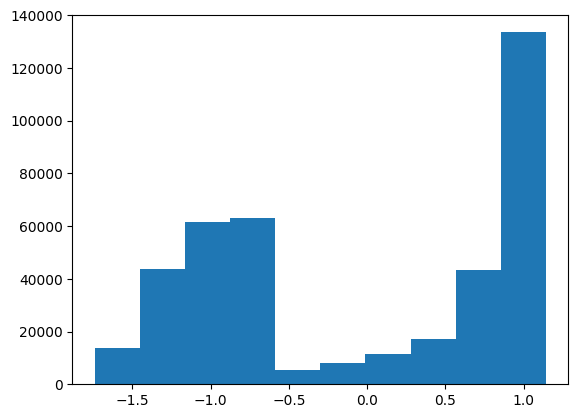

In [26]:
plt.hist(y_train_normalized)

(array([ 3520., 11091., 15085., 15827.,  1373.,  2093.,  2823.,  4213.,
        10676., 33491.]),
 array([-1.73978043, -1.45166524, -1.16355004, -0.87543484, -0.58731964,
        -0.29920445, -0.01108925,  0.27702595,  0.56514114,  0.85325634,
         1.14137154]),
 <BarContainer object of 10 artists>)

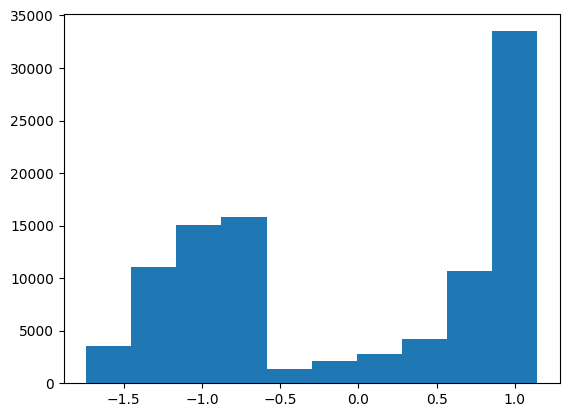

In [27]:
plt.hist(y_test_normalized)

In [28]:
x_train_normalized.shape[1:]

(13,)

In [29]:
feature_names = filtered_inputs.columns

In [30]:
# teste de outros modelos de IA
model1 = LinearRegression()
model1.fit(x_train_normalized, y_train_normalized)

LinearRegression()

In [31]:
model1.score(x_test_normalized, y_test_normalized)

0.6509989380332433

In [32]:
# Get the metrics on the validation data
predicted_availability1 = model1.predict(x_test_normalized)
mae1 = mean_absolute_error(y_test_normalized, predicted_availability1)
print('Linear test MAE = ', mae1)

Linear test MAE =  tf.Tensor([0.62877545 0.70477295 0.3032016  ... 0.34463736 0.24538656 0.8235419 ], shape=(100192,), dtype=float64)


In [33]:
mean_mae1 = tf.math.reduce_mean(mae1)
print('Linear test mean MAE = ', mean_mae1)
std_mae1 = tf.math.reduce_std(mae1)
print('Linear test std MAE = ', std_mae1)

Linear test mean MAE =  tf.Tensor(0.4928923863516948, shape=(), dtype=float64)
Linear test std MAE =  tf.Tensor(0.3265560903122043, shape=(), dtype=float64)


In [34]:
mse1 = mean_squared_error(y_test_normalized, predicted_availability1)
rmse1 = mse1**.5
print('Linear test MSE = ', mse1)
print('Linear test RMSE = ', rmse1)

Linear test MSE =  tf.Tensor([0.39535857 0.49670491 0.09193121 ... 0.11877491 0.06021456 0.67822126], shape=(100192,), dtype=float64)
Linear test RMSE =  tf.Tensor([0.62877545 0.70477295 0.3032016  ... 0.34463736 0.24538656 0.8235419 ], shape=(100192,), dtype=float64)


In [35]:
mean_mse1 = tf.math.reduce_mean(mse1)
print('Linear test mean MSE = ', mean_mse1)
mean_rmse1 = tf.math.reduce_mean(rmse1)
print('Linear test mean RMSE = ', mean_rmse1)

Linear test mean MSE =  tf.Tensor(0.34958178464346085, shape=(), dtype=float64)
Linear test mean RMSE =  tf.Tensor(0.4928923863516948, shape=(), dtype=float64)


In [36]:
model2 = RandomForestRegressor()
model2.fit(x_train_normalized, y_train_normalized.T[0])

RandomForestRegressor()

In [37]:
# save model
joblib.dump(model2, "random_forest_dsbal.joblib")

['random_forest_dsbal.joblib']

In [38]:
model2.score(x_test_normalized, y_test_normalized.T[0])

0.8735411276774756

In [39]:
# Get the metrics on the validation data
predicted_availability2 = model2.predict(x_test_normalized)

In [40]:
mae2 = mean_absolute_error(y_test_normalized.T[0], predicted_availability2)
print('Random forest test MAE = ', mae2)

Random forest test MAE =  tf.Tensor(0.2297855022854195, shape=(), dtype=float64)


In [41]:
mse2 = mean_squared_error(y_test_normalized.T[0], predicted_availability2)
rmse2 = mse2**.5
print('Random forest test MSE = ', mse2)
print('Random forest test RMSE = ', rmse2)

Random forest test MSE =  tf.Tensor(0.12666929441813135, shape=(), dtype=float64)
Random forest test RMSE =  tf.Tensor(0.35590630005400486, shape=(), dtype=float64)


In [42]:
params = model2.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

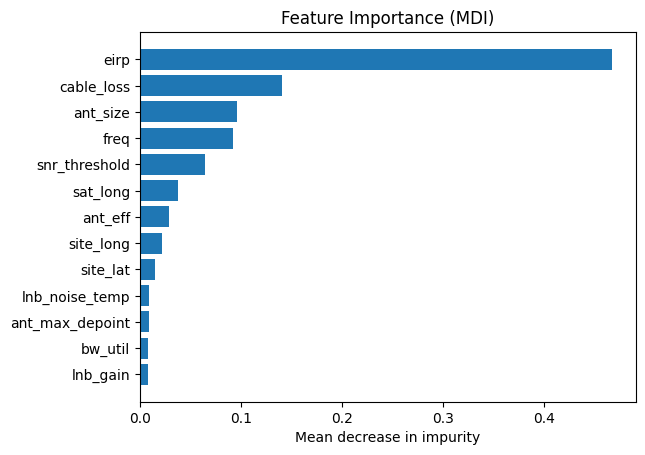

In [43]:
# obtain feature importance
feature_importance2 = model2.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance2)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance2[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

In [44]:
result2 = permutation_importance(
    model2, x_test_normalized, y_test_normalized.T[0], n_repeats=10, random_state=42, n_jobs=2
)

tree_importances2 = pd.Series(result2.importances_mean, index=feature_names)

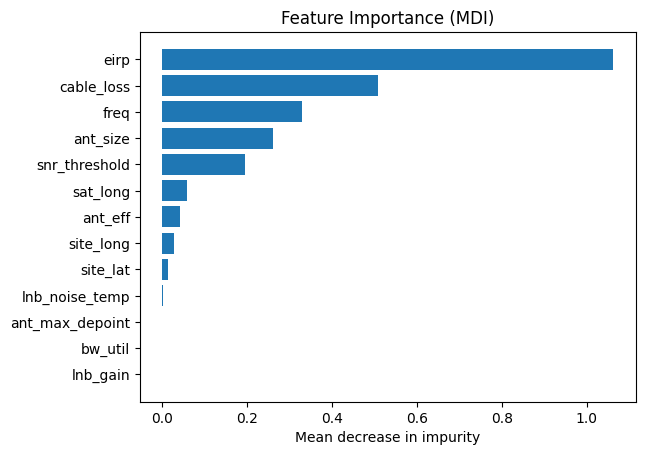

In [45]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances2)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances2[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

Text(0.5, 1.0, 'Permutation Importance (test set)')

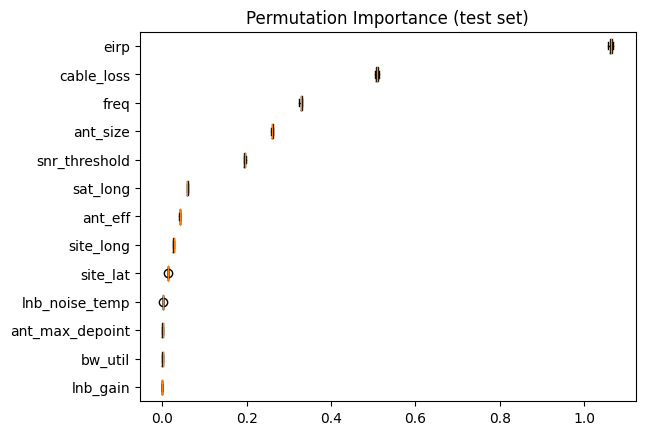

In [46]:
plt.boxplot(
    result2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [47]:
model3 = HistGradientBoostingRegressor()
model3.fit(x_train_normalized, y_train_normalized.T[0])

HistGradientBoostingRegressor()

In [48]:
# save model
joblib.dump(model3, "hist_grad_boost_dsbal.joblib")

['hist_grad_boost_dsbal.joblib']

In [49]:
model3.score(x_test_normalized, y_test_normalized.T[0])

0.8459450279837035

In [50]:
# Get the metrics on the validation data
predicted_availability3 = model3.predict(x_test_normalized)

In [51]:
mae3 = mean_absolute_error(y_test_normalized.T[0], predicted_availability3)
print('Hist. Grad. Boost. test MAE = ', mae3)

Hist. Grad. Boost. test MAE =  tf.Tensor(0.2854780436309248, shape=(), dtype=float64)


In [52]:
mse3 = mean_squared_error(y_test_normalized.T[0], predicted_availability3)
rmse3 = mse3**.5
print('Hist. Grad. Boost. test MSE = ', mse3)
print('Hist. Grad. Boost. test RMSE = ', rmse3)

Hist. Grad. Boost. test MSE =  tf.Tensor(0.15431131282856997, shape=(), dtype=float64)
Hist. Grad. Boost. test RMSE =  tf.Tensor(0.3928247864233747, shape=(), dtype=float64)


In [53]:
params = model3.get_params()
params

{'categorical_features': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'quantile': None,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

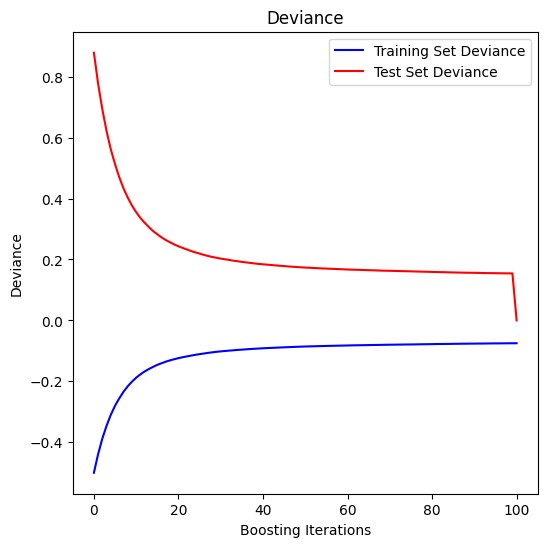

In [54]:
test_score = np.zeros((params["max_iter"]+1,), dtype=np.float64)

for i, y_pred in enumerate(model3.staged_predict(x_test_normalized)):
    test_score[i] = mean_squared_error(y_test_normalized.T[0], y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["max_iter"]+1),
    model3.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["max_iter"]+1), test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.show()

In [55]:
result3 = permutation_importance(
    model3, x_test_normalized, y_test_normalized.T[0], n_repeats=10, random_state=42, n_jobs=2
)

tree_importances3 = pd.Series(result3.importances_mean, index=feature_names)

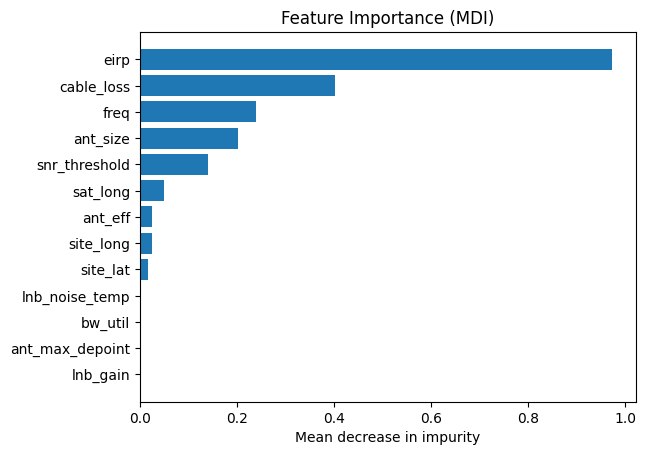

In [56]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances3)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances3[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

Text(0.5, 1.0, 'Permutation Importance (test set)')

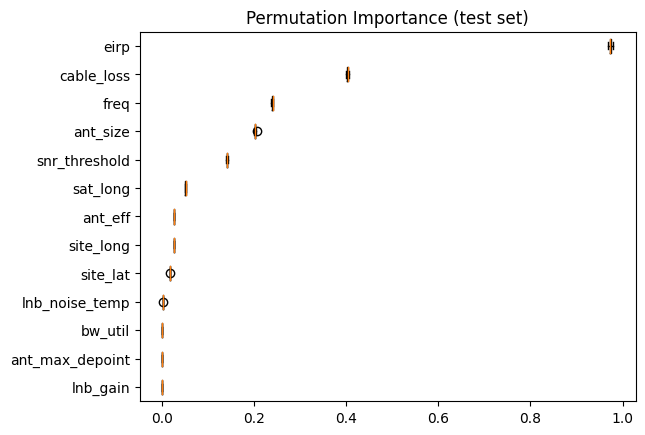

In [57]:
plt.boxplot(
    result3.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [58]:
eval_set = [(x_train_normalized, y_train_normalized), (x_test_normalized, y_test_normalized)]
model4 = xgb.XGBRegressor()
model4.fit(x_train_normalized, 
           y_train_normalized, 
           verbose=True,
           eval_set=eval_set)

[0]	validation_0-rmse:0.81100	validation_1-rmse:0.81202
[1]	validation_0-rmse:0.68610	validation_1-rmse:0.68716
[2]	validation_0-rmse:0.60541	validation_1-rmse:0.60654
[3]	validation_0-rmse:0.55203	validation_1-rmse:0.55361
[4]	validation_0-rmse:0.51763	validation_1-rmse:0.51966
[5]	validation_0-rmse:0.49390	validation_1-rmse:0.49618
[6]	validation_0-rmse:0.47719	validation_1-rmse:0.48006
[7]	validation_0-rmse:0.46457	validation_1-rmse:0.46766
[8]	validation_0-rmse:0.45338	validation_1-rmse:0.45689
[9]	validation_0-rmse:0.44612	validation_1-rmse:0.44985
[10]	validation_0-rmse:0.43842	validation_1-rmse:0.44246
[11]	validation_0-rmse:0.43390	validation_1-rmse:0.43814
[12]	validation_0-rmse:0.43039	validation_1-rmse:0.43474
[13]	validation_0-rmse:0.42594	validation_1-rmse:0.43047
[14]	validation_0-rmse:0.42385	validation_1-rmse:0.42847
[15]	validation_0-rmse:0.42059	validation_1-rmse:0.42547
[16]	validation_0-rmse:0.41801	validation_1-rmse:0.42304
[17]	validation_0-rmse:0.41580	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [59]:
# save model
joblib.dump(model4, "xgboost_dsbal.joblib")

['xgboost_dsbal.joblib']

In [60]:
results4 = model4.evals_result()
results4

{'validation_0': OrderedDict([('rmse',
               [0.8110010835565238,
                0.6860950778876584,
                0.6054139149166382,
                0.5520320914106264,
                0.5176317701702451,
                0.4938982023166725,
                0.47719349971378006,
                0.4645725933422869,
                0.4533768751770634,
                0.446115574438981,
                0.43842116901733824,
                0.43390195982492447,
                0.430385667672901,
                0.4259410422160041,
                0.4238478903315629,
                0.42059193079175494,
                0.4180145766411939,
                0.4158016862409479,
                0.41441297965290785,
                0.4120753588994757,
                0.4105356490300115,
                0.40899352085463825,
                0.40776879229037505,
                0.4069505387690313,
                0.4051019397773201,
                0.4041026506998954,
                0.40

In [63]:
model4.score(x_test_normalized, y_test_normalized.T[0])

0.8615035941351056

In [64]:
# Get the metrics on the validation data
predicted_availability4 = model4.predict(x_test_normalized)

In [65]:
mae4 = mean_absolute_error(y_test_normalized.T[0], predicted_availability4)
print('XGBoost test MAE = ', mae4)

XGBoost test MAE =  tf.Tensor(0.2702326, shape=(), dtype=float32)


In [66]:
mse4 = mean_squared_error(y_test_normalized.T[0], predicted_availability4)
rmse4 = mse4**.5
print('XGBoost test MSE = ', mse4)
print('XGBoost test RMSE = ', rmse4)

XGBoost test MSE =  tf.Tensor(0.13872686, shape=(), dtype=float32)
XGBoost test RMSE =  tf.Tensor(0.37246054, shape=(), dtype=float32)


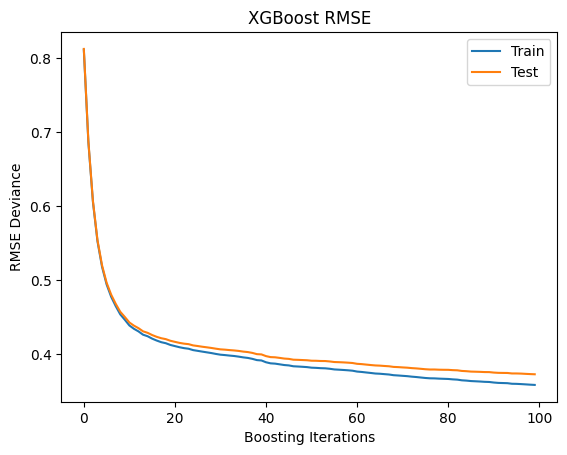

In [67]:
epochs = len(results4['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results4['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results4['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");

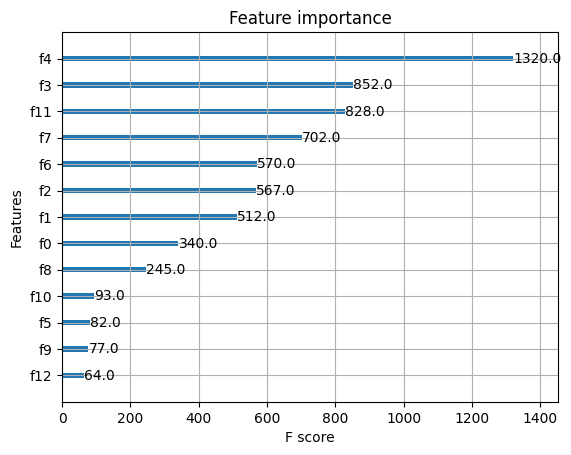

In [68]:
xgb.plot_importance(model4);

In [69]:
result4 = permutation_importance(
    model4, x_test_normalized, y_test_normalized.T[0], n_repeats=10, random_state=42, n_jobs=2
)

In [70]:
tree_importances4 = pd.Series(result4.importances_mean, index=feature_names)

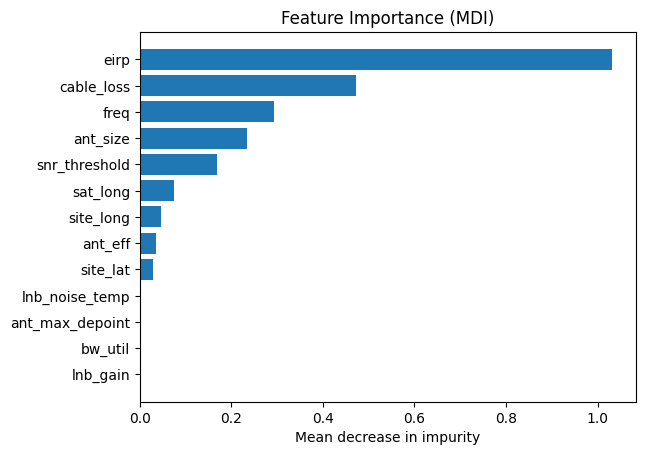

In [71]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances4)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances4[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

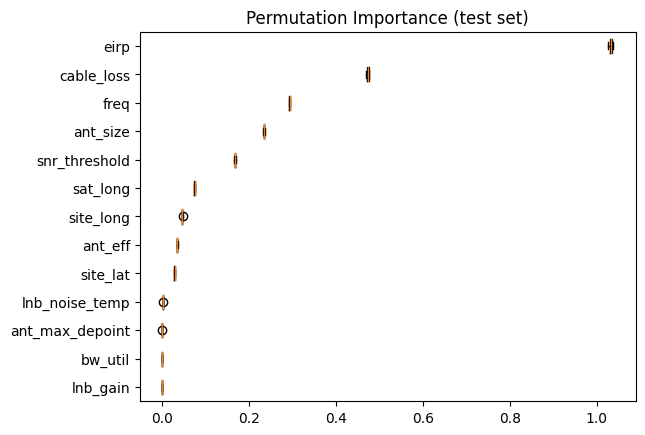

In [72]:
plt.boxplot(
    result4.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

In [73]:
model6 = VotingRegressor([("linear", model1), ("random-forest", model2), ("hist-grad-boost-reg", model3), ("xgb", model4)])  
model6.fit(x_train_normalized, y_train_normalized.T[0])

VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('random-forest', RandomForestRegressor()),
                            ('hist-grad-boost-reg',
                             HistGradientBoostingRegressor()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [74]:
# save model
joblib.dump(model6, "voting_dsbal.joblib")

['voting_dsbal.joblib']

In [75]:
model6.score(x_test_normalized, y_test_normalized.T[0])

0.8487832253877726

In [76]:
predicted_availability6 = model6.predict(x_test_normalized)

In [77]:
mae6 = mean_absolute_error(y_test_normalized.T[0], predicted_availability6)
print('Voting test MAE = ', mae6)

Voting test MAE =  tf.Tensor(0.29186118524492605, shape=(), dtype=float64)


In [78]:
mse6 = mean_squared_error(y_test_normalized.T[0], predicted_availability6)
rmse6 = mse6**.5
print('Voting test MSE = ', mse6)
print('Voting test RMSE = ', rmse6)

Voting test MSE =  tf.Tensor(0.15146839278674099, shape=(), dtype=float64)
Voting test RMSE =  tf.Tensor(0.3891894047719452, shape=(), dtype=float64)


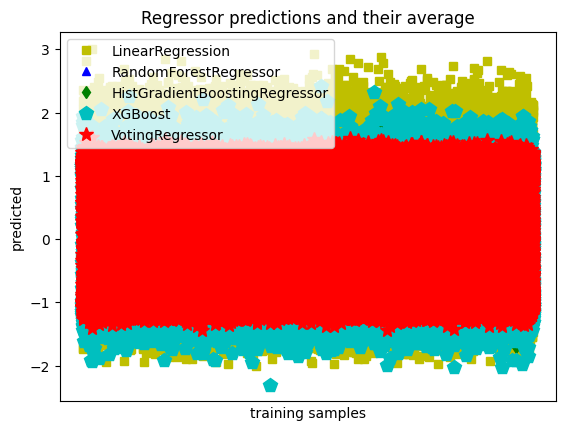

In [79]:
plt.figure()
plt.plot(predicted_availability1, "ys", label="LinearRegression")
plt.plot(predicted_availability2, "b^", label="RandomForestRegressor")
plt.plot(predicted_availability3, "gd", label="HistGradientBoostingRegressor")
plt.plot(predicted_availability4, "pc", ms=10, label="XGBoost")
plt.plot(predicted_availability6, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()